In [1]:
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import joblib 
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import time

In [4]:
df = pd.read_csv('../Data/eeg_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3437 entries, 0 to 3436
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   r1      3437 non-null   int64
 1   r2      3437 non-null   int64
 2   r3      3437 non-null   int64
 3   r4      3437 non-null   int64
 4   r5      3437 non-null   int64
 5   r6      3437 non-null   int64
 6   r7      3437 non-null   int64
 7   r8      3437 non-null   int64
 8   label   3437 non-null   int64
dtypes: int64(9)
memory usage: 241.8 KB


In [5]:
pp.ProfileReport(df)

In [6]:
df.columns

Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'label'], dtype='object')

In [7]:
X = df.drop('label', axis = 1)
y = df.label
X = StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=10)

In [8]:
#itterating to find the best k value
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.56540698, 0.58284884, 0.58284884, 0.58575581, 0.59593023,
       0.61046512, 0.58284884, 0.59447674, 0.58866279, 0.60174419,
       0.59593023, 0.59011628, 0.58866279, 0.59883721, 0.59447674,
       0.6002907 , 0.59447674, 0.59738372, 0.61046512, 0.61337209,
       0.60610465, 0.61337209, 0.6002907 , 0.61046512, 0.60465116,
       0.61046512, 0.61046512, 0.6119186 , 0.60901163])

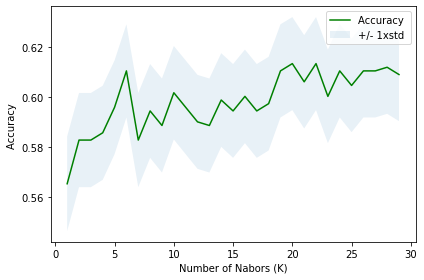

In [9]:
#Plot model accuracy for Different number of Neighbors

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10) #showing 68% data
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [12]:
scores=[]
best_estimators = {}


model_params = {  
    
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [4,5,6,7,8,16,17,18,19,20,21,22,23,24,25],
            'algorithm' : ['auto','ball_tree','kd_tree'],
            'weights' : ['uniform','distance'],
            'leaf_size' : [27,28,29,30,31,32,33,34,35]
        }
    },
    
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'max_depth' : [None,1,2,6,5,4,3]
        }
    },
    
    
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [30,35,40,45,50,55,58,60,65,70],
            'learning_rate' : [0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2],
            'algorithm' : ['SAMME', 'SAMME.R']
        }
    },
    
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            
        }
    },
    
     'LOGISTIC_REGRESSION': {
        'model': LogisticRegression(),
        'params': {
            'C': [1,2,3,4,5,6,7,8,9,10],
            'solver' : [ 'liblinear', 'lbfgs'],
            'multi_class' : ['auto', 'ovr' ]
        }
    },
    
        
    'SVM': {
        'model': SVC(),
        'params': {
             'C': [1,2,3,5,6,7],
             'kernel': ['rbf','linear'],
             'gamma': ['auto', 'scale']
        }
    },
       
    'RANDOM_FOREST':{
        'model' : RandomForestClassifier(),
        'params': {
            'n_estimators':[1,2,3,4,5,10,15,20,25,30],
            'criterion': ['entropy'],
            'random_state' : [11,12,13],
            'max_depth' : [4,5,6]

        }
    }
}

In [13]:
import time


for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    print(mp['model'], mp['params'])
    start_time = time.time()
    
    clf.fit(X_train, y_train)    
    

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': str(clf.best_params_)
    })
    best_estimators[model_name] = clf.best_estimator_
    print('{} minutes'.format((time.time() - start_time)/60))

KNeighborsClassifier() {'n_neighbors': [4, 5, 6, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'weights': ['uniform', 'distance'], 'leaf_size': [27, 28, 29, 30, 31, 32, 33, 34, 35]}
1.3752543846766154 minutes
DecisionTreeClassifier() {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 2, 6, 5, 4, 3]}
0.011210167407989502 minutes
AdaBoostClassifier() {'n_estimators': [30, 35, 40, 45, 50, 55, 58, 60, 65, 70], 'learning_rate': [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2], 'algorithm': ['SAMME', 'SAMME.R']}
2.077509641647339 minutes
GaussianNB() {}
0.00020017623901367188 minutes
LogisticRegression() {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'solver': ['liblinear', 'lbfgs'], 'multi_class': ['auto', 'ovr']}
0.011154810587565104 minutes
SVC() {'C': [1, 2, 3, 5, 6, 7], 'kernel': ['rbf', 'linear'], 'gamma': ['auto', 'scale']}
0.22897432645161947 minutes
RandomForestClassifier() {'n_estimators': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30], 'criterion': ['e

In [14]:
import pandas as pd    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2 = df2.sort_values(by='best_score',ascending=False)
df2

model  best_score  \
2      AdaBoostClassifier    0.642044   
6           RANDOM_FOREST    0.640591   
0    KNeighborsClassifier    0.639500   
5                     SVM    0.634417   
4     LOGISTIC_REGRESSION    0.626410   
1  DecisionTreeClassifier    0.618402   
3              GaussianNB    0.492897   

                                         best_params  
2  {'algorithm': 'SAMME', 'learning_rate': 0.8, '...  
6  {'criterion': 'entropy', 'max_depth': 5, 'n_es...  
0  {'algorithm': 'auto', 'leaf_size': 27, 'n_neig...  
5         {'C': 3, 'gamma': 'auto', 'kernel': 'rbf'}  
4  {'C': 1, 'multi_class': 'auto', 'solver': 'lbf...  
1           {'criterion': 'entropy', 'max_depth': 3}  
3                                                 {}

In [15]:
df2.best_params[0]

"{'algorithm': 'auto', 'leaf_size': 27, 'n_neighbors': 22, 'weights': 'distance'}"

In [16]:
cross_val_score(best_estimators['RANDOM_FOREST'],X_test,y_test,cv=5).mean()

0.6104199724955041

In [17]:
cross_val_score(best_estimators['KNeighborsClassifier'],X_test,y_test,cv=5).mean()

0.5668253464508621

In [18]:
cross_val_score(best_estimators['GaussianNB'],X_test,y_test,cv=5).mean()

0.48556013963821004

In [19]:
cross_val_score(best_estimators['DecisionTreeClassifier'],X_test,y_test,cv=5).mean()

0.5945096794668359

In [20]:
cross_val_score(best_estimators['SVM'],X_test,y_test,cv=5).mean()

0.5959060615677563

In [21]:
cross_val_score(best_estimators['LOGISTIC_REGRESSION'],X_test,y_test,cv=5).mean()

0.5784089706971332

In [22]:
cross_val_score(best_estimators['AdaBoostClassifier'],X_test,y_test,cv=5).mean()

0.6075108431185867

In [23]:
best_clf = best_estimators['RANDOM_FOREST']
best_clf

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30,
                       random_state=12)

In [24]:
print(classification_report(y_test,best_clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.63      0.87      0.73       399
           0       0.61      0.29      0.39       289

    accuracy                           0.62       688
   macro avg       0.62      0.58      0.56       688
weighted avg       0.62      0.62      0.59       688



In [29]:
class_dict = {'Prone to brain stroke':0, 'Normal': -1}

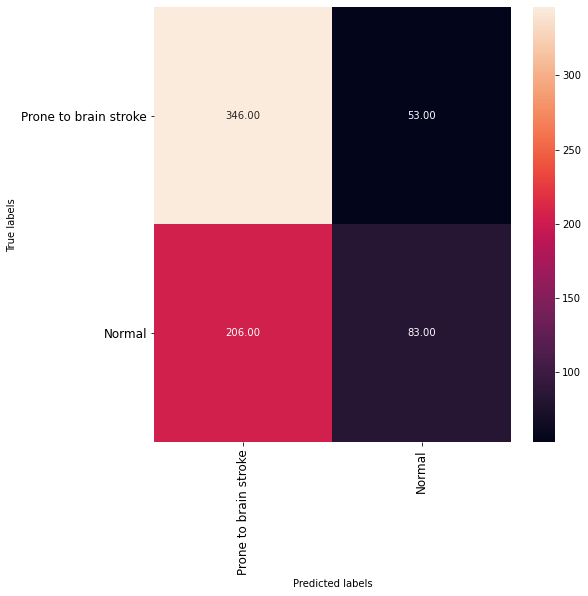

In [39]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

fig, ax = plt.subplots(figsize=(8,8))

g = sns.heatmap(cm,annot=True,ax=ax,fmt='.2f')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 12)
ax.xaxis.set_ticklabels(class_dict.keys()); ax.yaxis.set_ticklabels(class_dict.keys());
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

In [42]:
X = df.drop('label', axis = 1)
y = df.label

from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('RandomForest', RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30,
                       random_state=12))])

pipe.fit(X,y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForest',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=30, random_state=12))])

In [45]:
pipe.predict(X)

array([-1, -1, -1, ...,  0, -1, -1], dtype=int64)

In [46]:
import joblib 
joblib.dump(pipe, 'brain_saved_model.pkl')

['brain_saved_model.pkl']

In [47]:
import json
with open("brain_class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))